# 寿县飞艇观测数据：2024臭氧个例分析

## WRF模拟MDA8臭氧地面分布
---
Evan \
2024-10-30

In [15]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader

import configparser
config = configparser.ConfigParser()
config.read('../src/config.ini')

import warnings
warnings.filterwarnings("ignore")

In [2]:
datapath = config.get('chem', 'saprc')

# 读取指定时间范围内的数据
year  = 2024
month = 4
days  = np.arange(7,15)
hours = list(range(1, 24)) + [0] # 使hour按照1-23,0的顺序排列
filelist = []
for day in days:
    date = f'{year}{month:02d}{day:02d}'
    for hour in hours:
        if hour != 0:
            filelist.append(datapath + date + '/' + f'wrfout_d01_{year}-{month:02d}-{day:02d}_{hour:02d}:00:00')
        else:
            # 第n天路径下包含n+1天0时刻的数据，即第n天的0时刻数据位于n-1天的路径下
            filelist.append(datapath + date + '/' + f'wrfout_d01_{year}-{month:02d}-{day+1:02d}_00:00:00')

# 批量读取数据
ds = xr.open_mfdataset(filelist, combine='nested', concat_dim='Time')

In [3]:
# 构造本地时间索引
start_time = pd.to_datetime('2024-04-07 01:00:00') + pd.Timedelta(hours=8) # UTC+8
timestamps = [start_time + pd.Timedelta(hours=i) for i in range(len(filelist))]
time_index = pd.DatetimeIndex(timestamps)
# 将时间索引写入时间维
ds = ds.assign_coords(Time=('Time', time_index))

In [4]:
o3 = ds['o3'].sel(bottom_top=0)*1000 # 单位转换为ppb

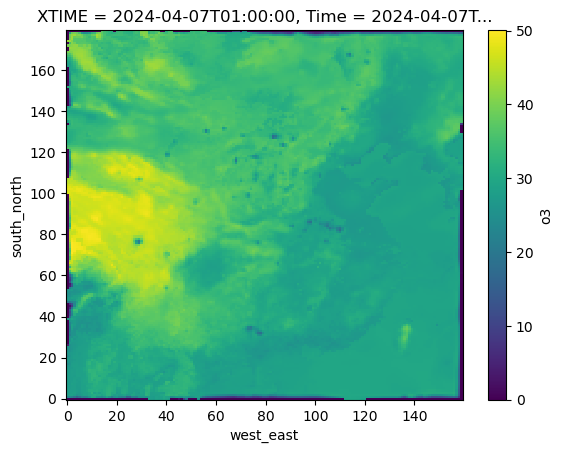

In [5]:
o3[0,:,:].plot()

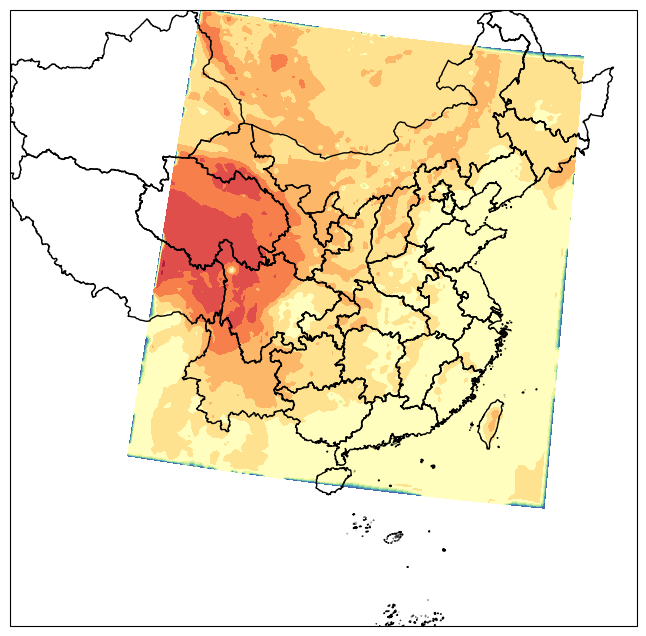

In [77]:
shp = config.get('boundary','shapefile')
province = Reader(shp+'sheng.shp')
province = cfeature.ShapelyFeature(Reader(shp+'sheng.shp').geometries(), ccrs.PlateCarree(), edgecolor='k', facecolor='none')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=120, central_latitude=40, standard_parallels=(30, 60)))
ax.add_feature(province)
ax.set_extent([90, 130, 10, 50], crs=ccrs.PlateCarree())

lon = ds['XLONG'][0,:,:]
lat = ds['XLAT'][0,:,:]
ax.contourf(lon, lat, o3[0,:,:], levels=np.arange(0, 60, 5), cmap='Spectral_r', transform=ccrs.PlateCarree())

plt.show()

In [6]:
shp = config.get('boundary','shapefile')
province = Reader(shp+'sheng.shp')
province = cfeature.ShapelyFeature(Reader(shp+'sheng.shp').geometries(),
                                   ccrs.PlateCarree(), edgecolor='k', facecolor='none')

In [7]:
# 将o3按照时间维度计算MDA8
mda8 = o3.rolling(Time=8).mean(dim='Time').resample(Time='D').max(dim='Time')

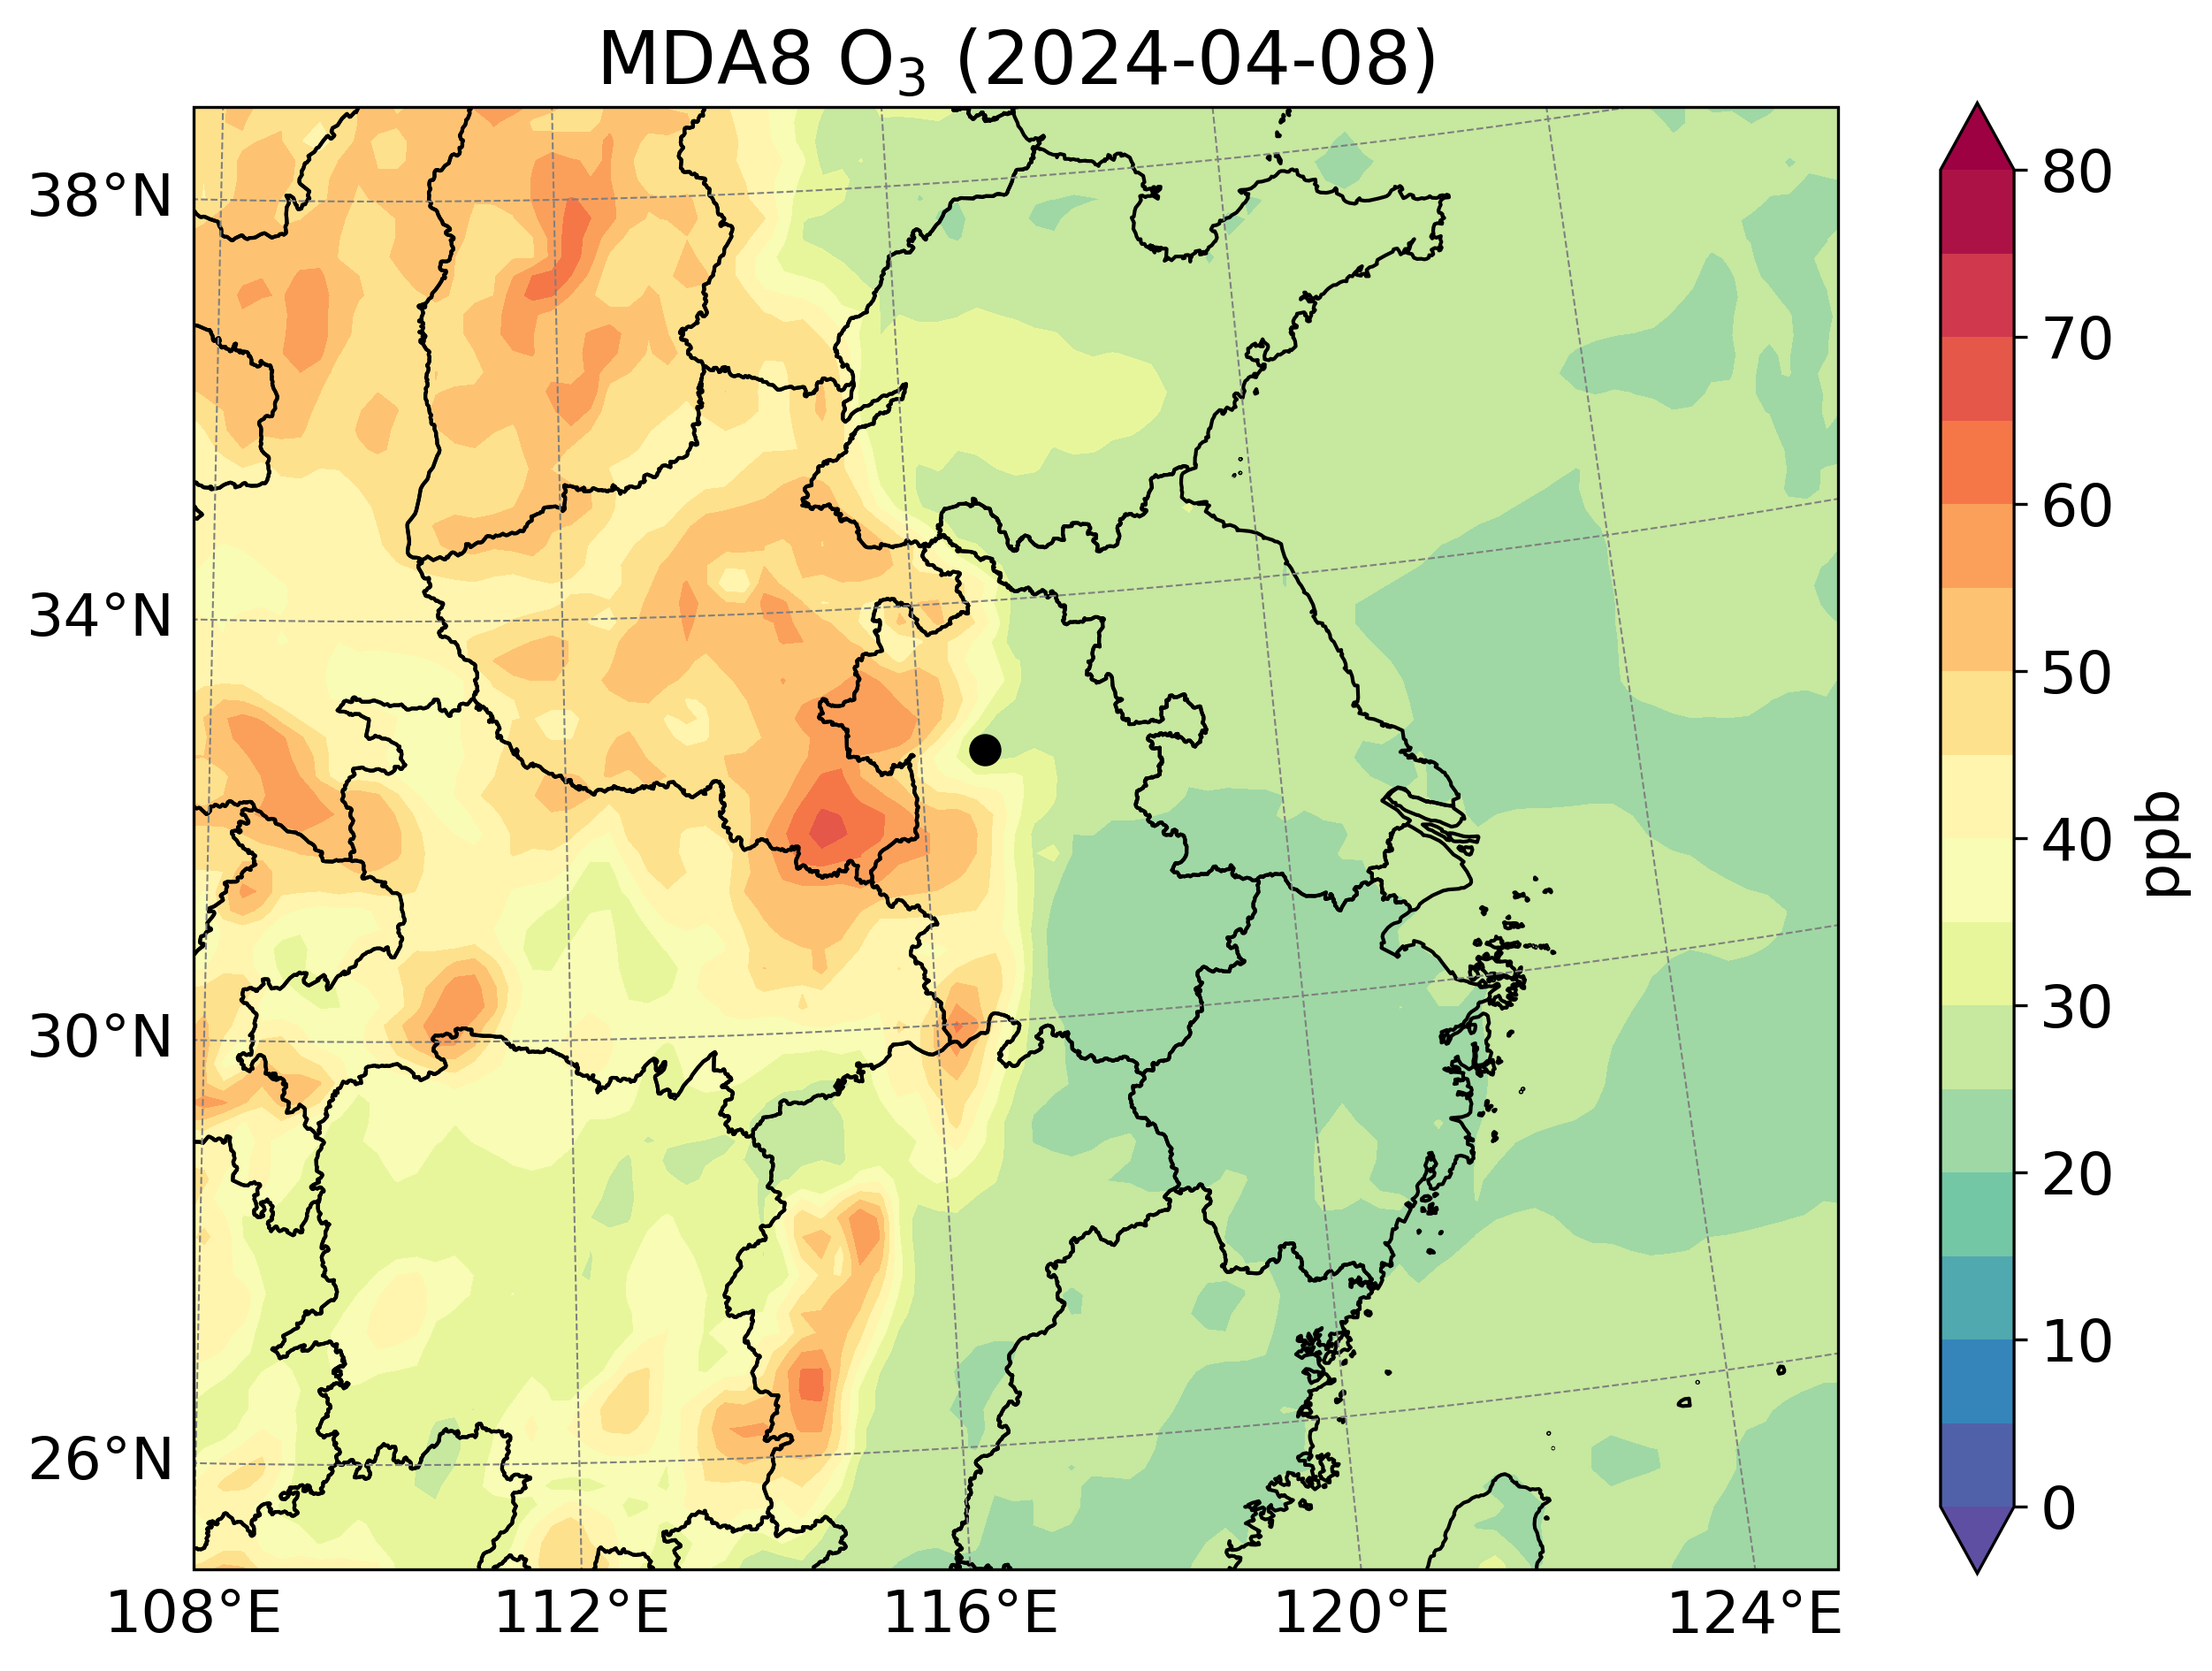

In [13]:
date = pd.to_datetime('2024-04-08')

fig = plt.figure(figsize=(10, 8),dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(
    central_longitude=110, central_latitude=40, standard_parallels=(20, 50)))
ax.add_feature(province)
ax.set_extent([108, 125, 25, 38], crs=ccrs.PlateCarree())
gl = ax.gridlines(
            xlocs=np.arange(-180, 180 + 1, 4), ylocs=np.arange(-90, 90 + 1, 4),
            draw_labels=True, x_inline=False, y_inline=False,
            linewidth=0.5, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.rotate_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

lon = ds['XLONG'][0,:,:]
lat = ds['XLAT'][0,:,:]
cf = ax.contourf(lon, lat, mda8.sel(Time=date), levels=np.arange(0, 81, 5),
                 extend='both',cmap='Spectral_r', transform=ccrs.PlateCarree())

cbar = fig.colorbar(cf, ax=ax, shrink=0.9)
cbar.set_ticks(np.arange(0, 81, 10))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('ppb', fontsize=16)

ax.scatter(116.72, 32.59, s=60, c='k', marker='o', transform=ccrs.PlateCarree())

ax.set_title(f'MDA8 O$_3$ ({date:%Y-%m-%d})', fontsize=20)
plt.show()

In [19]:
dates = pd.date_range('2024-04-08', '2024-04-14', freq='D')
outputpath = config.get('figure','mda_grd')

for date in dates:
    fig = plt.figure(figsize=(10, 8),dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(
        central_longitude=110, central_latitude=40, standard_parallels=(20, 50)))
    ax.add_feature(province)
    ax.set_extent([108, 125, 25, 38], crs=ccrs.PlateCarree())
    gl = ax.gridlines(
                xlocs=np.arange(-180, 180 + 1, 4), ylocs=np.arange(-90, 90 + 1, 4),
                draw_labels=True, x_inline=False, y_inline=False,
                linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.rotate_labels = False
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    lon = ds['XLONG'][0,:,:]
    lat = ds['XLAT'][0,:,:]
    cf = ax.contourf(lon, lat, mda8.sel(Time=date), levels=np.arange(0, 81, 5),
                    extend='both',cmap='Spectral_r', transform=ccrs.PlateCarree())

    cbar = fig.colorbar(cf, ax=ax, shrink=0.9)
    cbar.set_ticks(np.arange(0, 81, 10))
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('ppb', fontsize=16)

    ax.scatter(116.72, 32.59, s=60, c='k', marker='o', transform=ccrs.PlateCarree())

    ax.set_title(f'MDA8 O$_3$ ({date:%Y-%m-%d})', fontsize=20)
    plt.savefig(outputpath+date.strftime('%Y%m%d')+'.png',dpi=300,bbox_inches='tight')
    print('Complete:', date.strftime('%Y-%m-%d'))
    plt.close()

Complete: 2024-04-08
Complete: 2024-04-09
Complete: 2024-04-10
Complete: 2024-04-11
Complete: 2024-04-12
Complete: 2024-04-13
Complete: 2024-04-14
